In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import napari
from skimage.io import imread
import math
import scipy.interpolate as interpolate

In [2]:
def bicInter(img, amp, mesh):
    width, height = img.shape
    x=np.linspace(1, width, width)
    y=np.linspace(1, height, height)
    imgInter=interpolate.interp2d(x, y, img, kind='cubic')
    x2=np.linspace(1, width, width*amp)
    y2=np.linspace(1, height, height*amp)
    Z2 = imgInter(x2, y2)
    if mesh:
        Z2 = meshing(Z2, amp)
    return Z2

In [3]:
#Mesh compensation
def meshing(img, amp):
    width, height = img.shape
    desp = math.ceil(amp/2)
    imgPad = np.pad(img, desp, 'symmetric')
    imgS1 = imgPad[0:width, desp:height+desp]
    imgS2 = imgPad[(desp*2):width+(desp*2), desp:height+desp]
    imgS3 = imgPad[desp:width+desp, 0:height]
    imgS4 = imgPad[desp:width+desp, (desp*2):height+(desp*2)]
    imgF = (img + imgS1 + imgS2 + imgS3 + imgS4) / 5
    return imgF

In [4]:
#Spatial MSSR
def MSSR(img, psf, amp, order, mesh):
#    img = np.rot90(img, 1)
#    print(img[10,10])
    hs = round(0.4*psf*amp)
    maxValueImgOr = (max(map(max, img)))
    if(amp > 1):
        img = bicInter(img, amp, mesh)
    width, height = img.shape
    xPad = np.pad(img, hs, 'symmetric')
    M = np.zeros((width,height))
    for i in range(-hs, hs+1):
        for j in range(-hs, hs+1):
            if i!=0 or j!=0:
                xThis = xPad[hs+i:width+hs+i, hs+j:height+hs+j]
                M = np.maximum(M, np.absolute(img-xThis))
    
    weightAccum = np.zeros((width,height))
    yAccum = np.zeros((width,height))
    
    for i in range(-hs, hs+1):
        for j in range(-hs, hs+1):
            if i!=0 or j!=0:
                spatialkernel = np.exp(-(pow(i,2)+pow(j,2))/pow((hs),2))
                xThis = xPad[hs+i:width+hs+i, hs+j:height+hs+j]
                xDiffSq0 = pow((img-xThis)/M,2)
                intensityKernel = np.exp(-xDiffSq0)

                weightThis = spatialkernel*intensityKernel
                weightAccum = weightAccum + weightThis
                yAccum = yAccum + (xThis*weightThis)
    
    MS = img - (yAccum/weightAccum)
    MS[MS < 0] = 0
    MS[np.isnan(MS)] = 0
    
    I3 = MS/(max(map(max, MS)))
    x3 = img/(max(map(max, img)))
    for i in range(order):
        I4 = x3 - I3
        I5 = max(map(max, I4)) - I4
        I5 = I5/max(map(max, I5))
        I6 = I5*I3
        I7 = I6/max(map(max, I6))
        x3 = I3
        I3 = I7
    I3[np.isnan(I3)] = 0
#    I3 = np.rot90(I3, 3)
    IMSSR = I3*maxValueImgOr
    return I3

In [5]:
#Temporal MSSR
def TMSSR(img, psf, amp, order, mesh):
    nFrames, width, height = img.shape
    imgMSSR = np.zeros((nFrames,width*amp,height*amp))
    for nI in range(nFrames):
        imgMSSR[nI, :, :] = MSSR(img_raw[nI], psf, amp, order, mesh)
    return imgMSSR

In [6]:
#Temporal Product Mean
def TPM(img):
    nFrames, width, height = img.shape
    SumTPM = np.zeros((width,height))
    iTPM = np.zeros((width,height))
    for i in range(nFrames):
        SumTPM = SumTPM + img[i]
    for i in range(nFrames):
        iTPM = iTPM + (SumTPM * img[i])
    return iTPM

In [7]:
#Auto-Cummulants
def TRAC(img, k):
    nFrames, width, height = img.shape
    avg = np.mean(img, 0)
    d0 = np.absolute(img - avg)
    d1 = d0[1:nFrames, :, :]
    d2 = d0[2:nFrames, :, :]
    d3 = d0[3:nFrames, :, :]
    if k == 2:
        trac = np.mean(d0[1:nFrames, :, :]*d1,0)
    elif k == 3:
        trac = np.mean(d0[2:nFrames, :, :]*d1[1:nFrames, :, :]*d2,0)
    else:
        t1 = np.mean(d0[3:nFrames, :, :]*d1[2:nFrames, :, :]*d2[1:nFrames, :, :]*d3,0)
        t2 = np.mean(d0[3:nFrames, :, :]*d1[2:nFrames, :, :],0)*np.mean(d2[1:nFrames, :, :]*d3,0)
        t3 = np.mean(d0[3:nFrames, :, :]*d2[1:nFrames, :, :],0)*np.mean(d1[2:nFrames, :, :]*d3,0)
        t4 = np.mean(d0[3:nFrames, :, :]*d3,0)*np.mean(d1[2:nFrames, :, :]*d2[1:nFrames, :, :],0)
        trac = np.absolute(t1-t2-t3-t4)
    return trac

In [8]:
#Parameters
amp = 5
psf = 3
order = 0
mesh = True

In [9]:
img_raw = imread('raw7_100_PSFCHECK_561_DONUTS_33MS_5POWERL.tif')

if 'viewer' not in globals():
    viewer = napari.Viewer()
viewer.add_image(img_raw, colormap = 'magma')

imgRawMean = np.mean(img_raw, 0)
viewer.add_image(imgRawMean, colormap = 'magma')
imgAmpMean = bicInter(imgRawMean, amp, False)
viewer.add_image(imgAmpMean, colormap = 'magma')

<Image layer 'imgAmpMean' at 0x7fd77a5828e0>

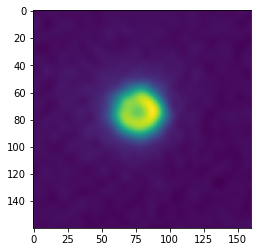

In [10]:
plt.imshow(imgAmpMean)

In [11]:
#Computing Temporal MSSR
imgMSSR = TMSSR(img_raw, psf, amp, order, mesh)
#print(imgMSSR.shape)


In [12]:
iMean = np.mean(imgMSSR, 0)
viewer.add_image(iMean, colormap = 'magma')

iVar = np.var(imgMSSR, 0)
viewer.add_image(iVar, colormap = 'magma')

iTPM = TPM(imgMSSR)
viewer.add_image(iTPM, colormap = 'magma')

iTRAC2 = TRAC(imgMSSR, 2)
viewer.add_image(iTRAC2, colormap = 'magma')
iTRAC3 = TRAC(imgMSSR, 3)
viewer.add_image(iTRAC3, colormap = 'magma')
iTRAC4 = TRAC(imgMSSR, 4)
viewer.add_image(iTRAC4, colormap = 'magma')

<Image layer 'iTRAC4' at 0x7fd778716f10>